In [109]:
"""
Koden henter laksedata fra SSB og gj√∏r dataen om til en tabell for alle verdiene som brukes videre i prosjektet ved hjelp av Pandas.
"""

import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivot√©r data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

    # Del opp "Tid" i √Ör og Uke
    df_pivot["√Ör"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at √Ör og Uke kommer f√∏rst
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkef√∏lge = ["√Ör", "Uke"] + [col for col in df_pivot.columns if col not in ["√Ör", "Uke"]]
    df_pivot = df_pivot[kolonnerekkef√∏lge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["√Ör"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot



def main(): #henter main og behandler dataen og returnerer df_pivot
    try:
        data = fetch_data()
        df_pivot = process_data(data)
        return df_pivot  # returnerer dataene fra main()
    except Exception as e:
        print(e)
        return None

if __name__ == "__main__":
    df_pivot = main()  # mottar resultatet fra main()
    if df_pivot is not None:
        print(df_pivot.to_string(index=False))  # dataene printes her 



  √Ör  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14

In [110]:
"""
En samlet oversikt over statistisk analyse av laksedataene fra SSB, som viser gjennomsnitt, median og standardavvik for hver variabel over alle √•r.
"""

import numpy as np
import pandas as pd

#De ulike kolonnene i datasettet som vi bruker
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

#Regner ut statistikken for alle √•rene til sammen
samlet_statistikk = []

for kol in numeriske_kolonner:
    verdier = df_pivot[kol].dropna()
    samlet_statistikk.append({
        "Variabel": kol,
        "Gjennomsnitt": round(np.mean(verdier), 2),
        "Median": round(np.median(verdier), 2),
        "Standardavvik": round(np.std(verdier), 2)
    })


df_samlet_statistikk = pd.DataFrame(samlet_statistikk)
df_samlet_statistikk.set_index("Variabel", inplace=True)

#visualieres med en tabell som kan scrolle, bruker derfor HTML
from IPython.display import display, HTML

display(HTML(f"""
<div style="width:60%; padding:8px; border:1px solid #ddd; overflow:auto;">
{df_samlet_statistikk.to_html()}
</div>
"""))


/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_15587/2469737318.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Kategori", y="Kilospris", palette=["limegreen", "red"])


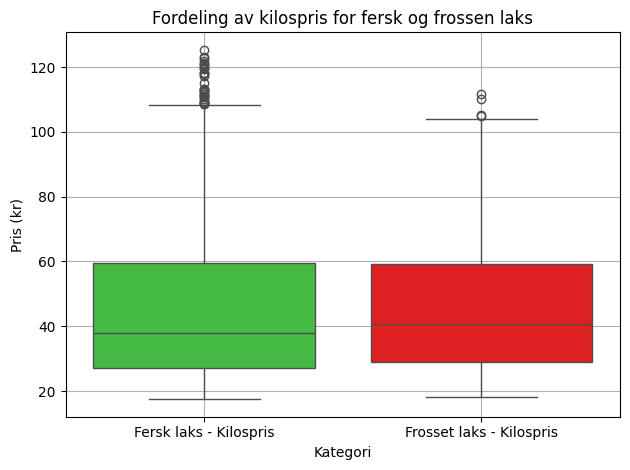

'\n    median vises av streken i midten av boksen \n    standardavvik vises av den laveste streken i diagrammet \n    gjennomsnittet vises av \n    prikkene helt √∏verst viser uteliggere og ekstreme verdier\n\n\n    M√Ö TENKE P√Ö OM DETTE SKAL FLYTTES TIL OPPGAVETEKSTEN.skal endres p√•.\nBoksplottet visualiserer sentrale statistiske m√•l som median og kvartiler. \nGjennomsnitt er ikke inkludert automatisk i plottet, men kan legges til. \nI dette tilfellet er gjennomsnittet n√¶r medianen, noe som indikerer en jevn fordeling, s√¶rlig for frosset laks.\n\n '

In [111]:
"""
Det kommer to bokser som viser fordelingen for kiloprisen av fersk og frossen laks.
Man kan her se om prisen er stabil eller om det er store prisfroskjeller.
Viser boxplot over ukentlig kilopris for fersk og frossen laks.

"""


import seaborn as sns
import matplotlib.pyplot as plt

# Lag "long" format for enklere plotting
df_long = df_pivot[[
    "Fersk laks - Kilospris", 
    "Frosset laks - Kilospris"
]].melt(var_name="Kategori", value_name="Kilospris")

sns.boxplot(data=df_long, x="Kategori", y="Kilospris", palette=["limegreen", "red"])
plt.title("Fordeling av kilospris for fersk og frossen laks")
plt.ylabel("Pris (kr)")
plt.grid(True)
plt.tight_layout()
plt.show()

"""
    median vises av streken i midten av boksen 
    standardavvik vises av den laveste streken i diagrammet 
    gjennomsnittet vises av 
    prikkene helt √∏verst viser uteliggere og ekstreme verdier

    
    M√Ö TENKE P√Ö OM DETTE SKAL FLYTTES TIL OPPGAVETEKSTEN.skal endres p√•.
Boksplottet visualiserer sentrale statistiske m√•l som median og kvartiler. 
Gjennomsnitt er ikke inkludert automatisk i plottet, men kan legges til. 
I dette tilfellet er gjennomsnittet n√¶r medianen, noe som indikerer en jevn fordeling, s√¶rlig for frosset laks.

 """


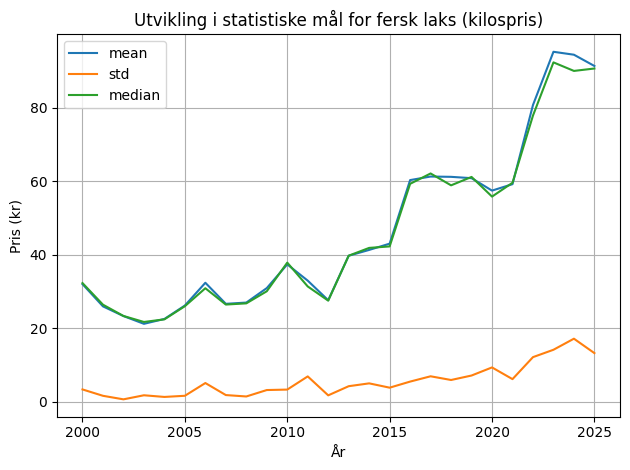

In [112]:
import matplotlib.pyplot as plt

df_plot = df_pivot.groupby("√Ör")["Fersk laks - Kilospris"].agg(["mean", "std", "median"])
df_plot.plot(title="Utvikling i statistiske m√•l for fersk laks (kilospris)")
plt.ylabel("Pris (kr)")
plt.xlabel("√Ör")
plt.grid(True)
plt.tight_layout()
plt.show()


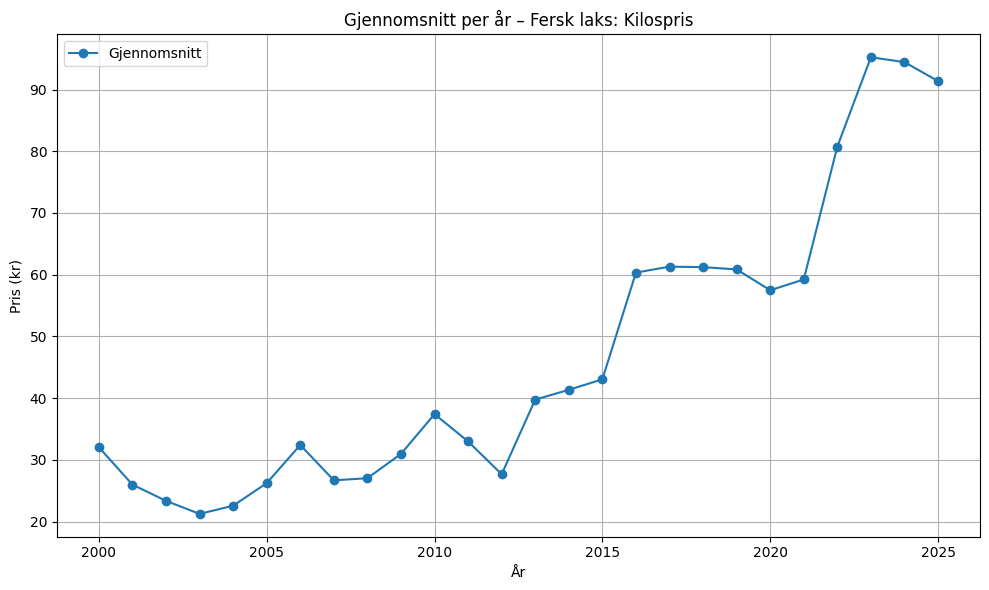

In [113]:
import matplotlib.pyplot as plt

# Beregn statistiske m√•l
df_plot = df_pivot.groupby("√Ör")["Fersk laks - Kilospris"].agg(["mean", "std", "median"])

# Plot kun gjennomsnittet
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot["mean"], label="Gjennomsnitt", marker="o")

plt.title("Gjennomsnitt per √•r ‚Äì Fersk laks: Kilospris")
plt.ylabel("Pris (kr)")
plt.xlabel("√Ör")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [114]:
from IPython.display import display, HTML
import numpy as np

# S√∏rg for at du har en '√Ör'-kolonne i df_pivot
if "√Ör" not in df_pivot.columns:
    df_pivot["√Ör"] = df_pivot["Tid"].str[:4].astype(int)

# Velg numeriske kolonner
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

# Liste for √• lagre resultater
statistikk_per_√•r = []



# G√• gjennom hvert √•r
for √•r in sorted(df_pivot["√Ör"].unique()):
    df_√•r = df_pivot[df_pivot["√Ör"] == √•r]
    for kol in numeriske_kolonner:
        verdier = df_√•r[kol].dropna()
        statistikk_per_√•r.append({
            "√Ör": √•r,
            "Variabel": kol,
            "Gjennomsnitt": round(np.mean(verdier), 2),
            "Median": round(np.median(verdier), 2),
            "Standardavvik": round(np.std(verdier), 2)
        })


df_stat_√•r = pd.DataFrame(statistikk_per_√•r)  #Lager selve dataframen med statistikken f√∏r bruk av pivot table til √• organisere dataene



# Bruk pivot_table for √• gj√∏re det oversiktlig
pivot = df_stat_√•r.pivot_table(
    index="√Ör", 
    columns="Variabel", 
    values=["Gjennomsnitt", "Median", "Standardavvik"]
)

# Sorter kolonne-niv√•ene for penere utskrift
pivot = pivot.sort_index(axis=1, level=0)



for m√•l in ["Gjennomsnitt", "Median", "Standardavvik"]:
    print(f"\nüîπ {m√•l}")
    visning = df_stat_√•r.pivot(index="√Ör", columns="Variabel", values=m√•l).round(2)
    display(HTML(visning.to_html()))




üîπ Gjennomsnitt



üîπ Median



üîπ Standardavvik


/var/folders/tm/w7fw79pn5hl46tszbnqf54840000gn/T/ipykernel_15587/461653907.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


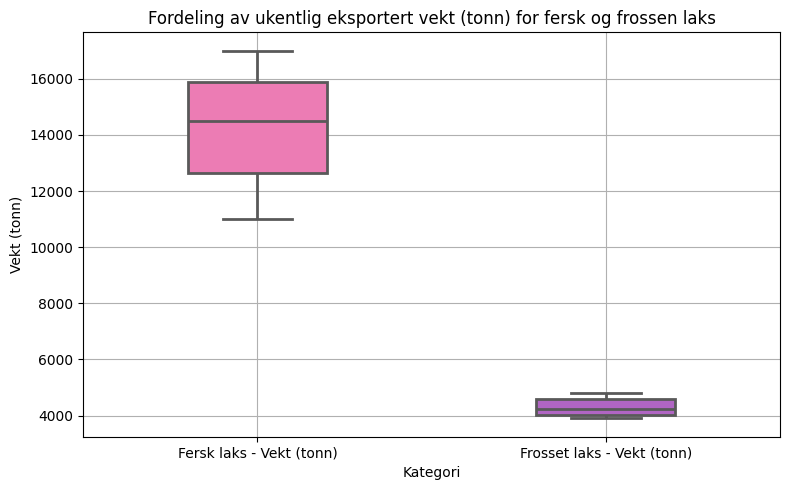

'\n    Her var det ingen uteliggere er det en feil? hvis ikke er det et godt tegn p√• at det ikke er store variasjoner i vekten av laksen som eksporteres.\n\n'

In [115]:
"""
Boxplottet viser tydelig at fersk laks har et h√∏yere og mer variert eksportvolum per uke enn frossen laks. 
Medianen ligger h√∏yere, og boksen er bredere noe som indikerer st√∏rre variasjon i vekten.
Det er ogs√• flere uteliggere i den ferske kategorien, noe som kan skyldes h√∏ysesonger eller spesielle eksporttopper.
"""


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Eksempeldata for boksplott over vekter ‚Äì simulerer df_pivot med vektverdier
# I faktisk bruk skal dette v√¶re din df_pivot med "Fersk laks - Vekt (tonn)" og "Frosset laks - Vekt (tonn)"
# Her bruker vi dummydata bare for visuell demonstrasjon
data = {
    "Fersk laks - Vekt (tonn)": [12000, 13000, 15000, 11000, 16000, 17000, 12500, 14000, 15500, 16500],
    "Frosset laks - Vekt (tonn)": [4000, 4500, 4800, 4300, 4100, 3900, 4700, 4600, 4200, 4000]
}
df_pivot_sim = pd.DataFrame(data)

# Gj√∏r dataen "long" for bruk i seaborn
df_long_vekt = df_pivot_sim[[
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Vekt (tonn)"
]].melt(var_name="Kategori", value_name="Vekt (tonn)")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_long_vekt, 
    x="Kategori", 
    y="Vekt (tonn)",
    width=0.4,
    showfliers=True,
    linewidth=2.0,
    palette=["hotpink", "mediumorchid"]  # oransje og lys bl√•
)




plt.title("Fordeling av ukentlig eksportert vekt (tonn) for fersk og frossen laks")
plt.grid(True)
plt.tight_layout()
plt.show()


"""
    Her var det ingen uteliggere er det en feil? hvis ikke er det et godt tegn p√• at det ikke er store variasjoner i vekten av laksen som eksporteres.
    
"""


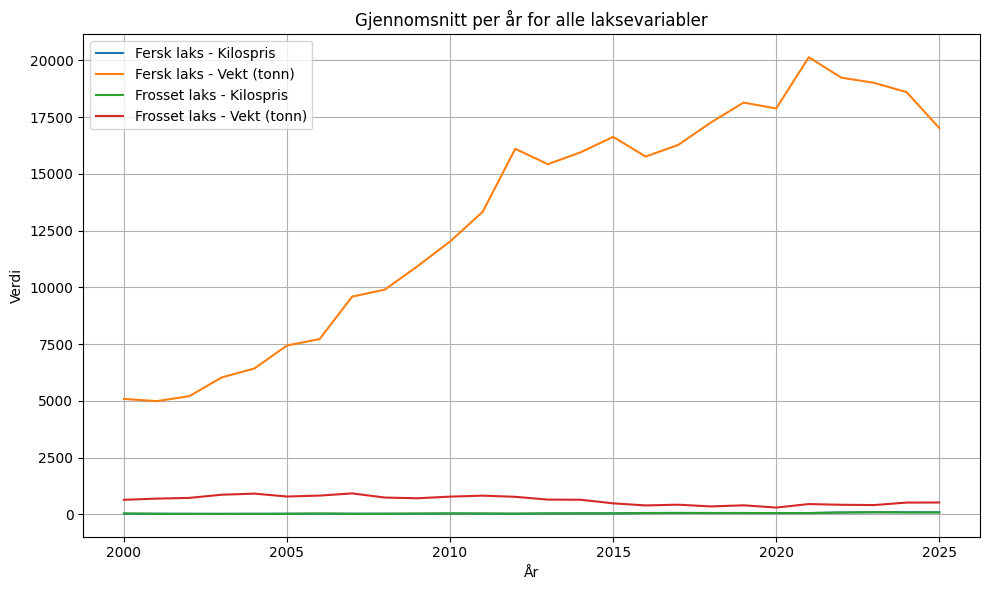

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for var in df_stat_√•r["Variabel"].unique():
    subset = df_stat_√•r[df_stat_√•r["Variabel"] == var]
    sns.lineplot(data=subset, x="√Ör", y="Gjennomsnitt", label=var, ax=ax)

plt.title("Gjennomsnitt per √•r for alle laksevariabler")
plt.ylabel("Verdi")
plt.xlabel("√Ör")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


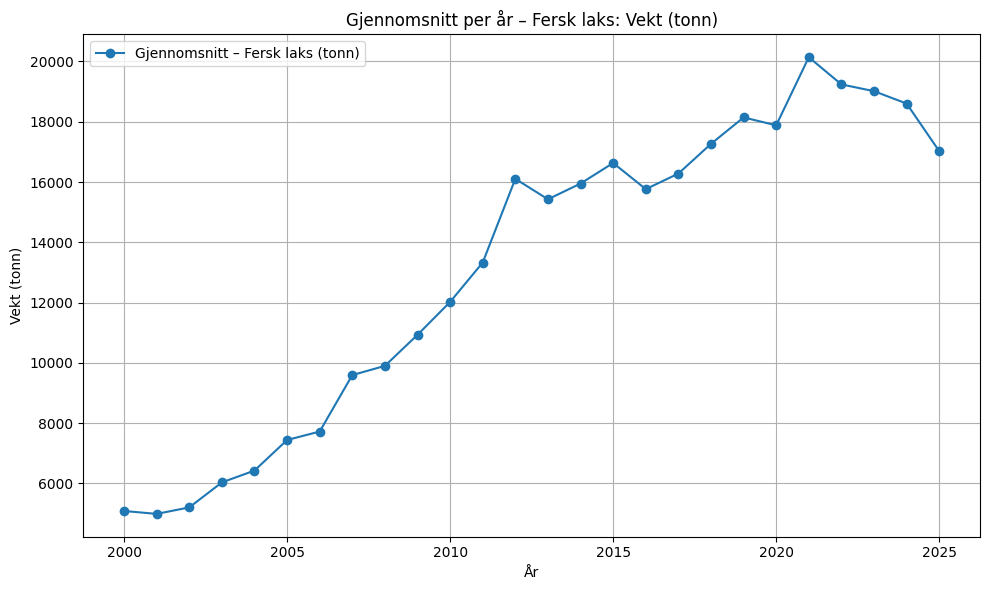

In [117]:
import matplotlib.pyplot as plt

# Beregn gjennomsnitt direkte
df_plot = df_pivot.groupby("√Ör")["Fersk laks - Vekt (tonn)"].mean().reset_index()

# Lag linjediagram
plt.figure(figsize=(10, 6))
plt.plot(df_plot["√Ör"], df_plot["Fersk laks - Vekt (tonn)"], label="Gjennomsnitt ‚Äì Fersk laks (tonn)", marker="o")

plt.title("Gjennomsnitt per √•r ‚Äì Fersk laks: Vekt (tonn)")
plt.xlabel("√Ör")
plt.ylabel("Vekt (tonn)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


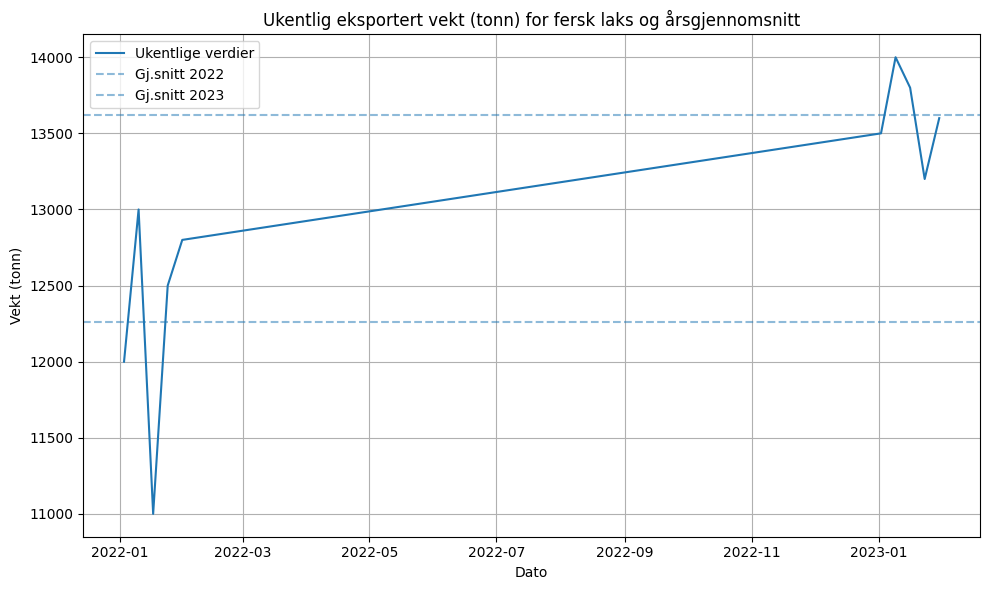

In [118]:
"""
    Plotter gjennomsnitt av ferks laks sin vekt i tonn vs vanlige originale verdier for fersk laks i tonn 
    Dette er viktig fordi det viser hvor ustabil eksportvolumet er per uke 
    Man kan se hvordan dataen per uke varierer i forhold til gjennomsnittet 
    sesongm√∏nster og topper blir mer synlig

"""



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Simulerer df_pivot og df_stat_√•r for demonstrasjon
data = {
    "√Ör": [2022]*5 + [2023]*5,
    "Uke": list(range(1, 6))*2,
    "UkeDato": pd.date_range(start="2022-01-03", periods=5, freq="W-MON").tolist() +
               pd.date_range(start="2023-01-02", periods=5, freq="W-MON").tolist(),
    "Fersk laks - Vekt (tonn)": [12000, 13000, 11000, 12500, 12800, 13500, 14000, 13800, 13200, 13600]
}
df_pivot = pd.DataFrame(data)

# Lag df_stat_√•r basert p√• df_pivot
statistikk_per_√•r = []
for √•r in sorted(df_pivot["√Ör"].unique()):
    df_√•r = df_pivot[df_pivot["√Ör"] == √•r]
    kol = "Fersk laks - Vekt (tonn)"
    verdier = df_√•r[kol].dropna()
    statistikk_per_√•r.append({
        "√Ör": √•r,
        "Variabel": kol,
        "Gjennomsnitt": round(np.mean(verdier), 2),
        "Median": round(np.median(verdier), 2),
        "Standardavvik": round(np.std(verdier), 2)
    })

df_stat_√•r = pd.DataFrame(statistikk_per_√•r)

# Plot originale verdier og gjennomsnitt per √•r
plt.figure(figsize=(10, 6))

# Originale ukentlige verdier
sns.lineplot(data=df_pivot, x="UkeDato", y="Fersk laks - Vekt (tonn)", label="Ukentlige verdier")

# Gjennomsnitt per √•r lagt som horisontale linjer
for _, row in df_stat_√•r.iterrows():
    plt.axhline(y=row["Gjennomsnitt"], linestyle="--", alpha=0.5, label=f"Gj.snitt {int(row['√Ör'])}")

plt.title("Ukentlig eksportert vekt (tonn) for fersk laks og √•rsgjennomsnitt")
plt.xlabel("Dato")
plt.ylabel("Vekt (tonn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



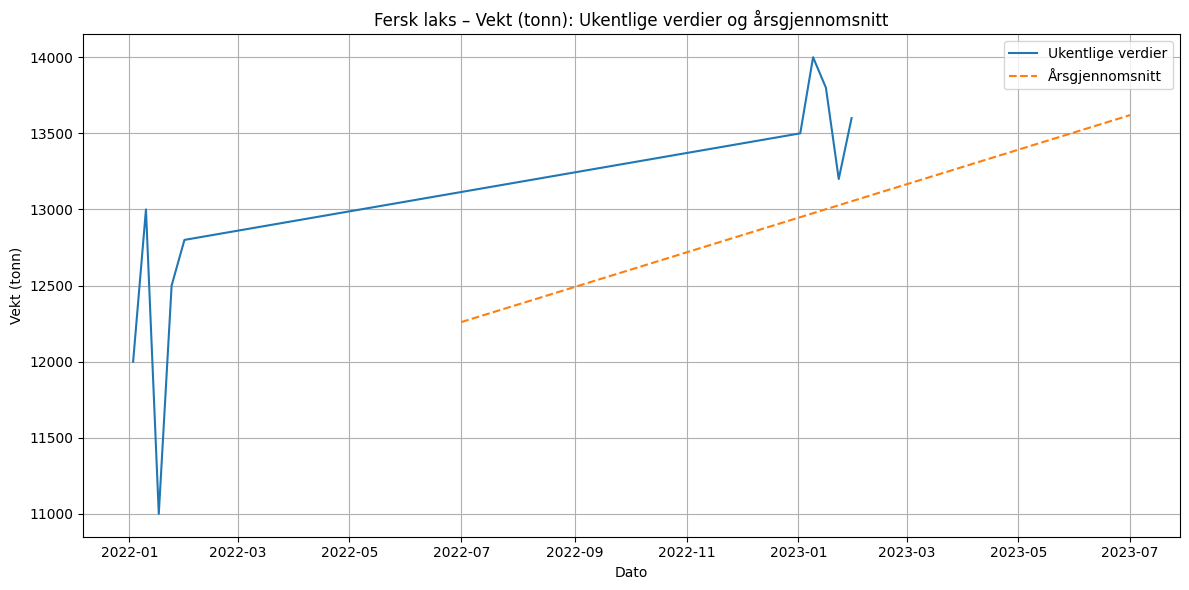

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Originale ukentlige verdier
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pivot, x="UkeDato", y="Fersk laks - Vekt (tonn)", label="Ukentlige verdier")

# 2. Gjennomsnitt per √•r
df_gjennomsnitt = df_pivot.groupby("√Ör")["Fersk laks - Vekt (tonn)"].mean().reset_index()
df_gjennomsnitt["Dato"] = pd.to_datetime(df_gjennomsnitt["√Ör"].astype(str) + "-07-01")

sns.lineplot(data=df_gjennomsnitt, x="Dato", y="Fersk laks - Vekt (tonn)", label="√Örsgjennomsnitt", linestyle="--")

# Stil og layout
plt.title("Fersk laks ‚Äì Vekt (tonn): Ukentlige verdier og √•rsgjennomsnitt")
plt.xlabel("Dato")
plt.ylabel("Vekt (tonn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
